# Segmentación – Proyecto Telco Customer Churn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle


## Descargamos X y y limpios, pero sin train, test o smote

In [2]:
with open("data_clean.pkl", "rb") as f:
    payload = pickle.load(f)

X = payload["X"]
y = payload["y"]


In [3]:
X = X.copy()
y = y.copy()


In [4]:
X.shape, y.shape

((7043, 23), (7043,))

In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Gender                                  7043 non-null   int64  
 1   Senior Citizen                          7043 non-null   int64  
 2   Partner                                 7043 non-null   int64  
 3   Dependents                              7043 non-null   int64  
 4   Tenure Months                           7043 non-null   int64  
 5   Phone Service                           7043 non-null   int64  
 6   Multiple Lines                          7043 non-null   int64  
 7   Online Security                         7043 non-null   int64  
 8   Online Backup                           7043 non-null   int64  
 9   Device Protection                       7043 non-null   int64  
 10  Tech Support                            7043 non-null   int6

## Escalado de variables

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)   # numpy array

print("X_scaled shape:", X_scaled.shape)


X_scaled shape: (7043, 23)


## Aplicamos K-means

C:\tools\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] El sistema no puede encontrar el archivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\tools\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\tools\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\tools\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\tools\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, a

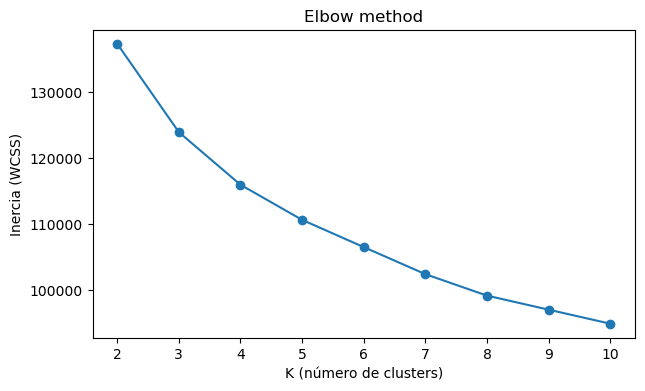

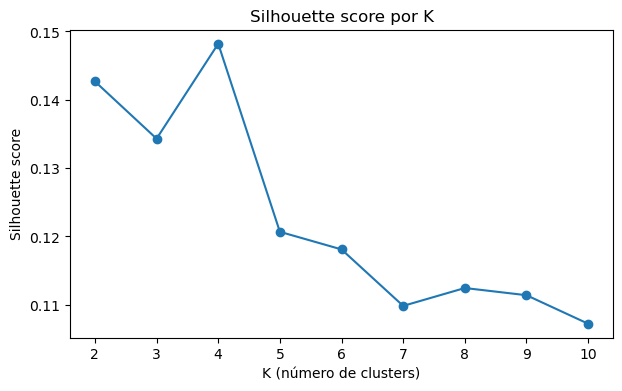

Tabla rápida:
K= 2  inertia=137,360.74  silhouette=0.1427
K= 3  inertia=123,958.57  silhouette=0.1343
K= 4  inertia=115,981.55  silhouette=0.1482
K= 5  inertia=110,657.39  silhouette=0.1207
K= 6  inertia=106,530.22  silhouette=0.1181
K= 7  inertia=102,424.71  silhouette=0.1098
K= 8  inertia=99,171.60  silhouette=0.1124
K= 9  inertia=97,042.35  silhouette=0.1114
K=10  inertia=94,915.67  silhouette=0.1072


In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

ks = range(2, 11)  # probamos K=2..10
inertias = []
silhouettes = []

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

# Elbow (inercia)
plt.figure(figsize=(7,4))
plt.plot(list(ks), inertias, marker="o")
plt.xlabel("K (número de clusters)")
plt.ylabel("Inercia (WCSS)")
plt.title("Elbow method")
plt.show()

# Silhouette
plt.figure(figsize=(7,4))
plt.plot(list(ks), silhouettes, marker="o")
plt.xlabel("K (número de clusters)")
plt.ylabel("Silhouette score")
plt.title("Silhouette score por K")
plt.show()

print("Tabla rápida:")
for k, iner, sil in zip(ks, inertias, silhouettes):
    print(f"K={k:2d}  inertia={iner:,.2f}  silhouette={sil:.4f}")


#### Pero como silhouette es bajo, lo normal es que los clusters sean “útiles” para segmentar (perfiles) más que para decir “existen 4 grupos naturales clarísimos”.

## Entrenar KMeans con K=4, crear la columna cluster y empezar a perfilar cada cluster

In [8]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)

clusters = kmeans.fit_predict(X_scaled)

# Creamos un dataframe con clusters (manteniendo el índice original)
df_cluster = X.copy()
df_cluster["cluster"] = clusters

# (Opcional pero útil) añadimos y para analizar churn por cluster
df_cluster["Churn Value"] = y.values

df_cluster["cluster"].value_counts().sort_index()


cluster
0     682
1    2498
2    2011
3    1852
Name: count, dtype: int64

In [9]:
# 1) Resumen por cluster: tamaño y churn rate
cluster_summary = (
    df_cluster
    .groupby("cluster")["Churn Value"]
    .agg(n_clientes="count", churn_rate="mean")
)

cluster_summary["churn_rate_pct"] = (cluster_summary["churn_rate"] * 100).round(2)

cluster_summary


,n_clientes,churn_rate,churn_rate_pct
cluster,,,
0,682,0.249267,24.93
1,2498,0.504804,50.48
2,2011,0.124316,12.43
3,1852,0.101512,10.15


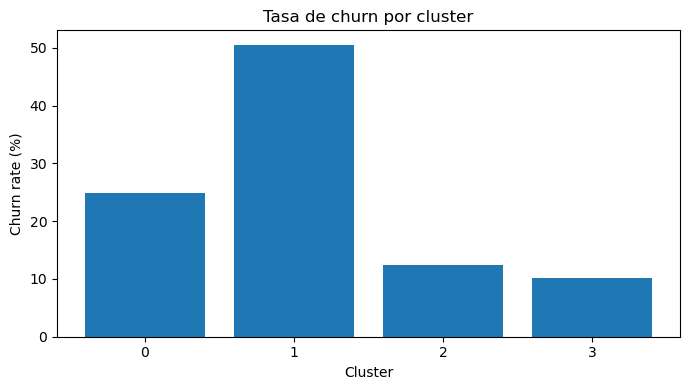

In [10]:
plt.figure(figsize=(7,4))
plt.bar(cluster_summary.index.astype(str), cluster_summary["churn_rate_pct"])
plt.xlabel("Cluster")
plt.ylabel("Churn rate (%)")
plt.title("Tasa de churn por cluster")

plt.tight_layout()
plt.savefig("cluster_bar.svg", bbox_inches="tight")
plt.show()


In [11]:
# Centroide de cada cluster (en espacio escalado)
centroids = kmeans.cluster_centers_

# Distancia entre centroides 2 y 3 (cuanto más pequeña, más similares)
dist_23 = np.linalg.norm(centroids[2] - centroids[3])
print("Distancia entre centroides (2 vs 3):", dist_23)

# Diferencias de medias por variable (en los datos originales X)
means = df_cluster.groupby("cluster")[X.columns].mean()
diff_23 = (means.loc[2] - means.loc[3]).abs().sort_values(ascending=False)

print("\nTop 10 variables más distintas entre cluster 2 y 3:")
print(diff_23.head(10))


Distancia entre centroides (2 vs 3): 5.114329699316128

Top 10 variables más distintas entre cluster 2 y 3:
CLTV                            584.499388
Monthly Charges                  63.989903
Tenure Months                    27.221388
Internet Service_no               0.823974
Streaming Movies                  0.709454
Streaming TV                      0.700631
Device Protection                 0.683850
Online Backup                     0.669002
Tech Support                      0.597082
Internet Service_fiber optic      0.570107
dtype: float64


## Tabla completa de variables por cluster (perfil)

In [12]:
# Asegúrate de que df_cluster tiene: features + cluster + Churn Value
# (como lo construimos antes)

# Resumen base
cluster_base = (
    df_cluster.groupby("cluster")["Churn Value"]
    .agg(n_clientes="count", churn_rate="mean")
)
cluster_base["churn_rate_pct"] = (cluster_base["churn_rate"] * 100).round(2)

# Medias de variables (para dummies 0/1 = % de clientes con ese "1")
cluster_means = df_cluster.groupby("cluster")[X.columns].mean()

# Unimos todo
cluster_profile = cluster_base.join(cluster_means)

# Ordenamos por churn rate (útil para leer)
cluster_profile = cluster_profile.sort_values("churn_rate", ascending=False)

# Para ver mejor en pantalla
pd.set_option("display.max_columns", 200)
cluster_profile


,n_clientes,churn_rate,churn_rate_pct,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Paperless Billing,Monthly Charges,CLTV,Internet Service_fiber optic,Internet Service_no,Contract_one year,Contract_two year,Payment Method_credit card (automatic),Payment Method_electronic check,Payment Method_mailed check
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2498,0.504804,50.48,0.499600,0.260608,0.317454,0.097678,17.459568,1.0,0.469576,0.166934,0.273819,0.260208,0.160929,0.395516,0.390713,0.761009,78.864011,4044.732586,0.775420,0.000000,0.053643,0.004003,0.108887,0.634508,0.110488
0,682,0.249267,24.93,0.514663,0.152493,0.456012,0.230205,31.737537,0.0,0.000000,0.414956,0.420821,0.447214,0.423754,0.417889,0.436950,0.567449,42.028592,4317.146628,0.000000,0.000000,0.212610,0.236070,0.225806,0.331378,0.233138
2,2011,0.124316,12.43,0.495276,0.160617,0.715564,0.280457,55.176032,1.0,0.704127,0.609647,0.698160,0.707608,0.636499,0.707111,0.717553,0.657384,90.333963,4925.120338,0.573347,0.000000,0.381900,0.433118,0.357036,0.211835,0.101442
3,1852,0.101512,10.15,0.518359,0.034557,0.463823,0.357451,27.954644,1.0,0.206263,0.050216,0.029158,0.023758,0.039417,0.006479,0.008099,0.302916,26.344060,4340.620950,0.003240,0.823974,0.230022,0.352592,0.204104,0.069114,0.525378


In [13]:
# Reutilizamos lo de antes
cluster_means = df_cluster.groupby("cluster")[X.columns].mean()
overall = df_cluster[X.columns].mean()

# Base: tamaño y churn
cluster_base = (
    df_cluster.groupby("cluster")["Churn Value"]
    .agg(n_clientes="count", churn_rate="mean")
)
cluster_base["churn_rate_pct"] = (cluster_base["churn_rate"] * 100).round(2)

cards = []

for c in sorted(df_cluster["cluster"].unique()):
    # Diferencias vs promedio global
    diff = (cluster_means.loc[c] - overall)
    top = diff.reindex(diff.abs().sort_values(ascending=False).head(5).index)

    # Formateo: si es dummy (0/1) lo interpretas como %; si es numérica, como media
    # (Aquí lo dejamos numérico para que tú lo leas con tu criterio)
    row = {
        "cluster": c,
        "n_clientes": int(cluster_base.loc[c, "n_clientes"]),
        "churn_rate_pct": float(cluster_base.loc[c, "churn_rate_pct"]),
    }

    # Añadimos las 5 variables como columnas (nombre + delta vs promedio)
    for i, (feat, val) in enumerate(top.items(), start=1):
        row[f"top{i}_feature"] = feat
        row[f"top{i}_delta_vs_avg"] = float(val)

    cards.append(row)

cluster_cards = pd.DataFrame(cards).sort_values("churn_rate_pct", ascending=False)
cluster_cards


,cluster,n_clientes,churn_rate_pct,top1_feature,top1_delta_vs_avg,top2_feature,top2_delta_vs_avg,top3_feature,top3_delta_vs_avg,top4_feature,top4_delta_vs_avg,top5_feature,top5_delta_vs_avg
1,1,2498,50.48,CLTV,-355.563169,Tenure Months,-14.911581,Monthly Charges,14.102319,Internet Service_fiber optic,0.335835,Payment Method_electronic check,0.298713
0,0,682,24.93,CLTV,-83.149127,Monthly Charges,-22.733100,Phone Service,-0.903166,Tenure Months,-0.633612,Internet Service_fiber optic,-0.439585
2,2,2011,12.43,CLTV,524.824583,Monthly Charges,25.572271,Tenure Months,22.804883,Device Protection,0.363721,Online Backup,0.353279
3,3,1852,10.15,CLTV,-59.674804,Monthly Charges,-38.417632,Tenure Months,-4.416505,Internet Service_no,0.607305,Internet Service_fiber optic,-0.436346


## Arriba vemos las 5 variables mas DISTINTIVAS / MÁS CARACTERISTICAS DE CADA CLUSTER

Varianza explicada PC1+PC2: 33.81 %


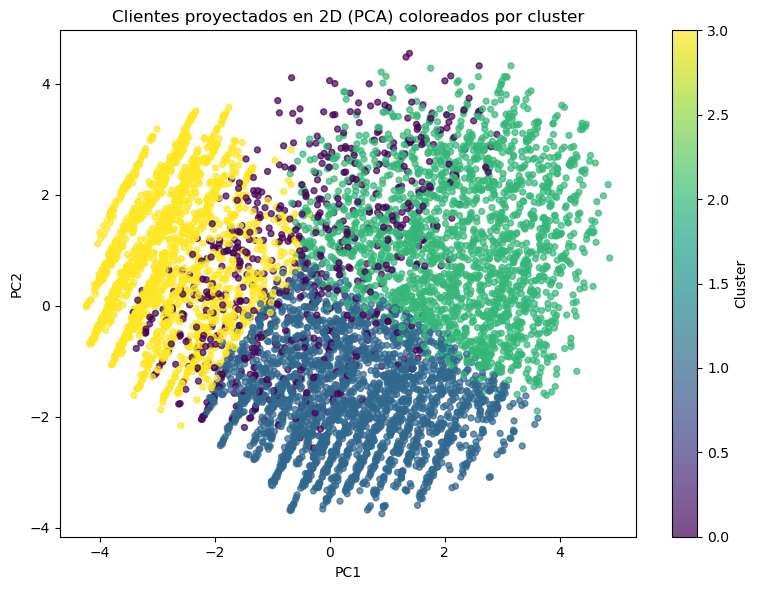

In [14]:
from sklearn.decomposition import PCA

# 1) PCA a 2 componentes sobre X_scaled
pca2 = PCA(n_components=2, random_state=42)
X_pca2 = pca2.fit_transform(X_scaled)

print("Varianza explicada PC1+PC2:",
      np.round(pca2.explained_variance_ratio_.sum()*100, 2), "%")

# 2) Scatter 2D coloreado por cluster
plt.figure(figsize=(8,6))
plt.scatter(
    X_pca2[:, 0], X_pca2[:, 1],
    c=df_cluster["cluster"],
    s=18,
    alpha=0.7
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Clientes proyectados en 2D (PCA) coloreados por cluster")
plt.colorbar(label="Cluster")

plt.tight_layout()
plt.savefig("cluster_scatter.svg", bbox_inches="tight")
plt.show()


### Usamos PCA a 2D solo para visualización. Como PC1+PC2 explican el 33.8% de la varianza, es esperable que algunos clusters se solapen en el plano 2D aunque estén separados en el espacio completo.”

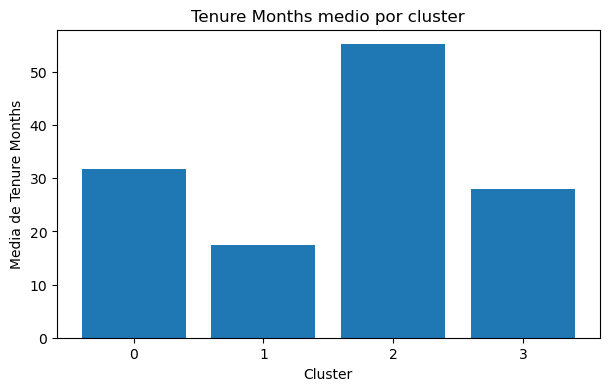

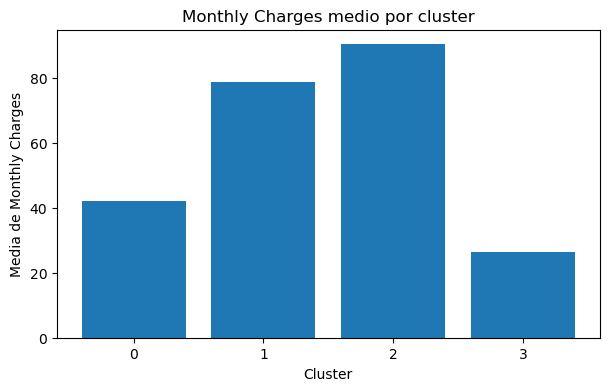

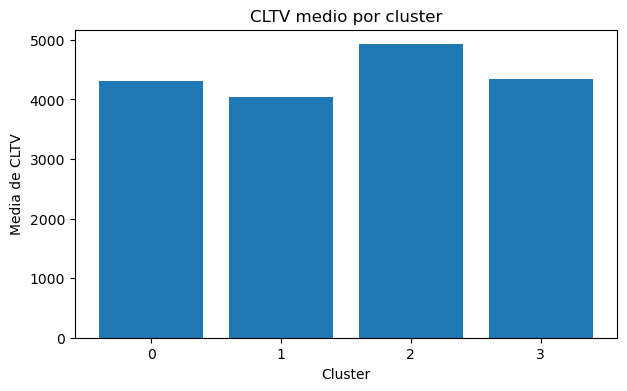

,Tenure Months,Monthly Charges,CLTV
cluster,,,
0,31.737537,42.028592,4317.146628
1,17.459568,78.864011,4044.732586
2,55.176032,90.333963,4925.120338
3,27.954644,26.344060,4340.620950


In [17]:
num_vars = ["Tenure Months", "Monthly Charges", "CLTV"]  # añade/quita aquí si quieres

cluster_num_means = df_cluster.groupby("cluster")[num_vars].mean()

for var in num_vars:
    plt.figure(figsize=(7,4))
    plt.bar(cluster_num_means.index.astype(str), cluster_num_means[var])
    plt.xlabel("Cluster")
    plt.ylabel(f"Media de {var}")
    plt.title(f"{var} medio por cluster")
    plt.show()

cluster_num_means
